<a href="https://colab.research.google.com/github/idasrr/Study-Group/blob/main/Text%20Classification_IMDB%20Film%20Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification dengan LSTM – IMDB Dataset

Proyek ini bertujuan membangun model sentiment analysis untuk mengklasifikasi review film menjadi positif atau negatif. Model dibangun menggunakan Bidirectional LSTM, yang umum dipakai untuk memahami konteks pada teks yang bersifat sekuensial.

Dataset yang digunakan merupakan IMDB Large Movie Review Dataset dengan total 50.000 file teks yang terbagi menjadi 25.000 untuk training dan 25.000 untuk testing.


## 1. Import Library

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

## 2. Load Dataset

In [14]:
df = pd.read_csv(
    "IMDB Dataset.csv",  # sesuaikan nama file yang terupload
    on_bad_lines='skip',
    encoding="utf-8",
    engine="python"
)

print(df.shape)
print(df.head())

(50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [15]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


<Axes: xlabel='count', ylabel='sentiment'>

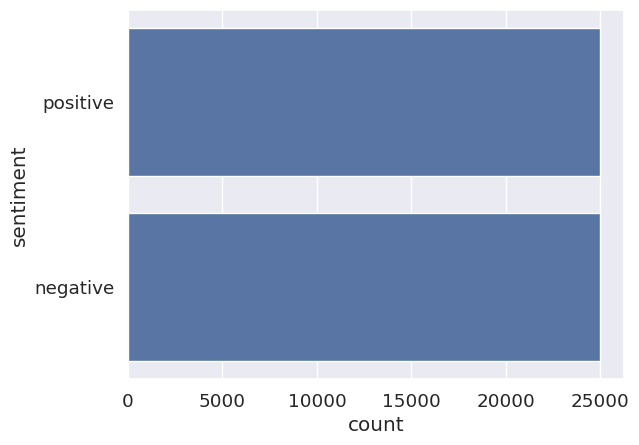

In [16]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.sentiment)

In [17]:
df.isna().sum()

,0
review,0
sentiment,0


In [18]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

<>:7: SyntaxWarning: invalid escape sequence '\['
<>:7: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-2930776120.py:7: SyntaxWarning: invalid escape sequence '\['
  return re.sub('\[[^]]*\]', '', text)


In [20]:
import string
import re # Ensure re is imported for re.sub

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove HTML entities
    text = re.sub(r'&\w+;', '', text)

    # Handle negations (don't -> do not, can't -> can not)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'m", " am", text)

    # Remove punctuation except negation words
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['clean_text'] = df['review'].apply(preprocess_text)

# Stopwords yang lebih komprehensif
local_stopwords = set([
    'i', 'me', 'my', 'myself', 'we', 'our',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'both', 'each', 'few',
    'more', 'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than',
    'too', 'very', 's', 't', 'can', 'will', 'just', 'should', 'now',
    # Add back 'ours' which was missing in the original code's `local_stopwords` for consistency
    'ours'
])

def remove_stopwords(text):
    words = text.split()
    # Keep negation words
    negation_words = {'not', 'no', 'never', 'neither', 'nobody', 'nothing', 'none'}
    filtered = [word for word in words if word not in local_stopwords or word in negation_words]
    return ' '.join(filtered)

df['clean_text'] = df['clean_text'].apply(remove_stopwords)

# Remove empty strings
df = df[df['clean_text'].str.len() > 0]
df = df.reset_index(drop=True)

print(f"\nJumlah data setelah cleaning: {len(df)}")


Jumlah data setelah cleaning: 49999


In [21]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

/tmp/ipython-input-3187148367.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.sentiment.replace("positive" , 1 , inplace = True)
/tmp/ipython-input-3187148367.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

,review,sentiment,clean_text
0,one reviewers mentioned watching oz episode ex...,1,one reviewers mentioned watching oz episode ex...
1,wonderful little filming technique fashion giv...,1,wonderful little filming technique fashion giv...
2,thought wonderful way spend time hot summer si...,1,thought wonderful way spend time hot summer si...
3,basically family little boy thinks zombie clos...,0,basically family little boy thinks zombie clos...
4,petter time visually stunning film mattei offe...,1,petter time visually stunning film mattei offe...


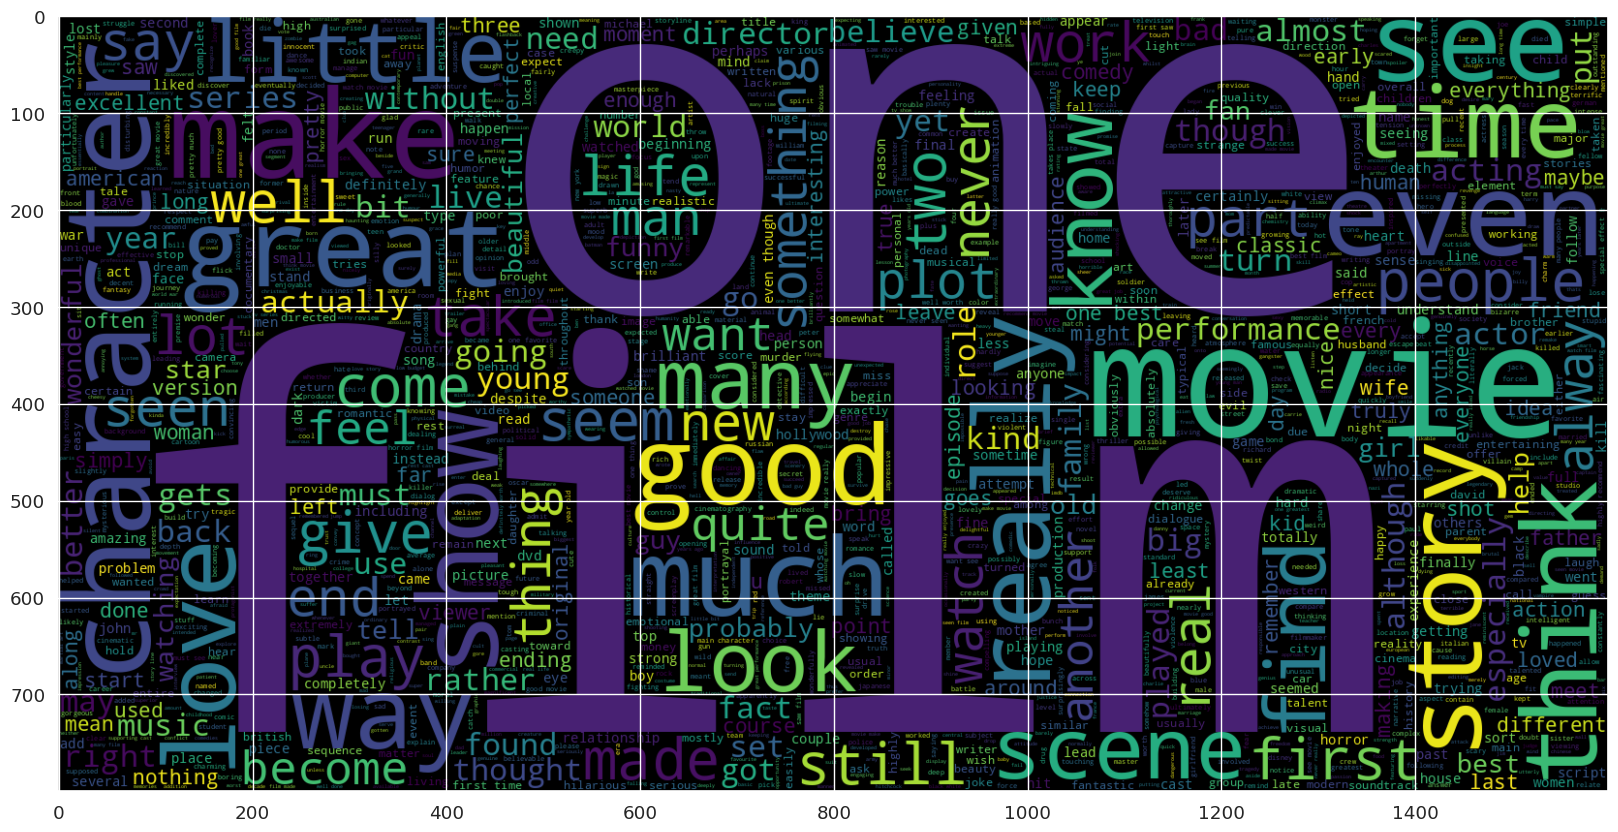

In [22]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

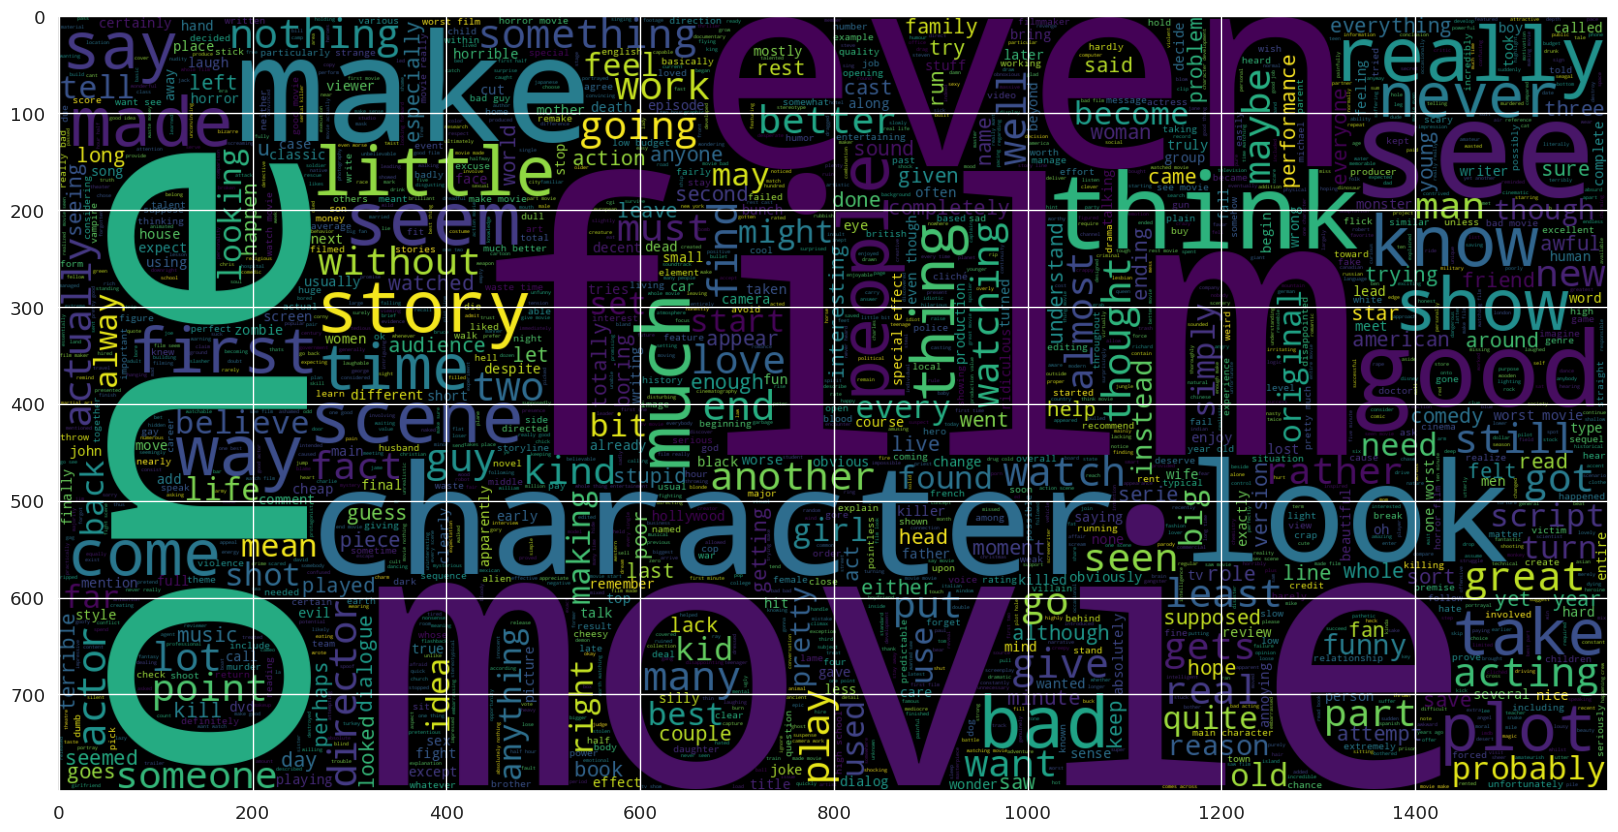

In [23]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

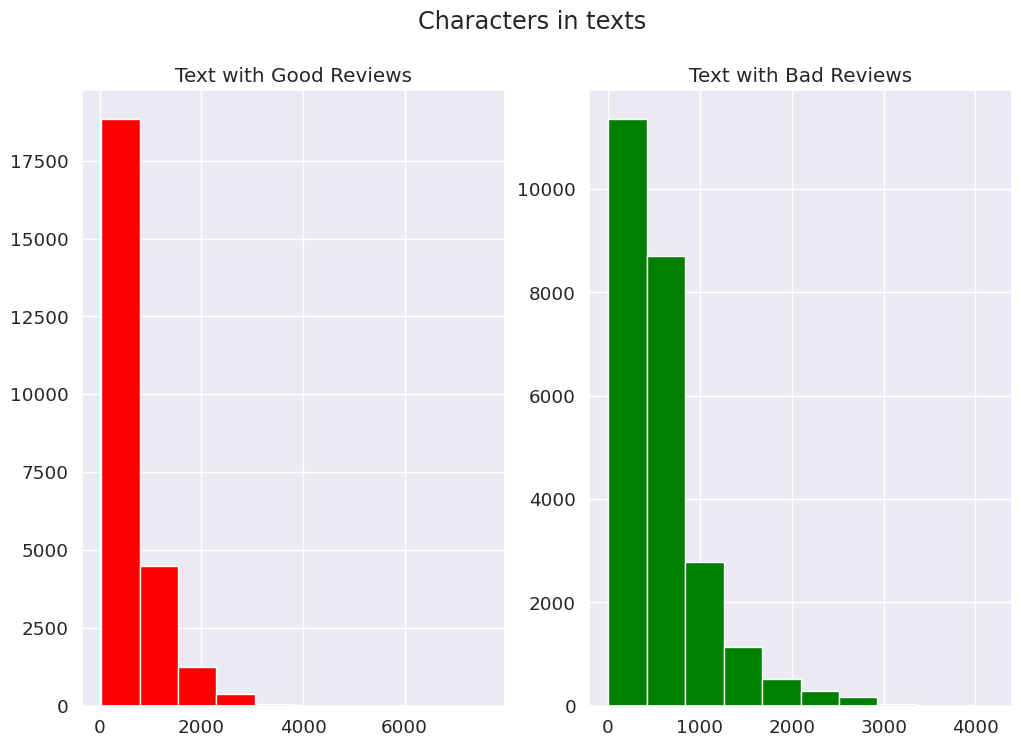

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

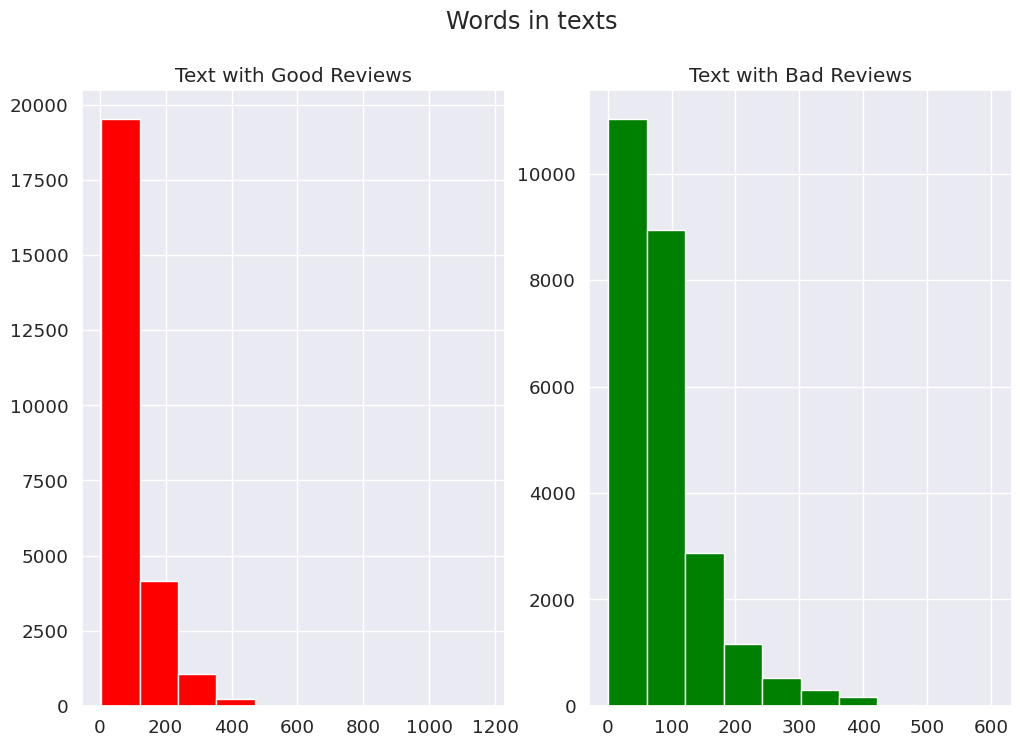

In [25]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Words in texts')
plt.show()

/tmp/ipython-input-1562264771.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
/tmp/ipython-input-1562264771.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')


Text(0.5, 0.98, 'Average word length in each text')

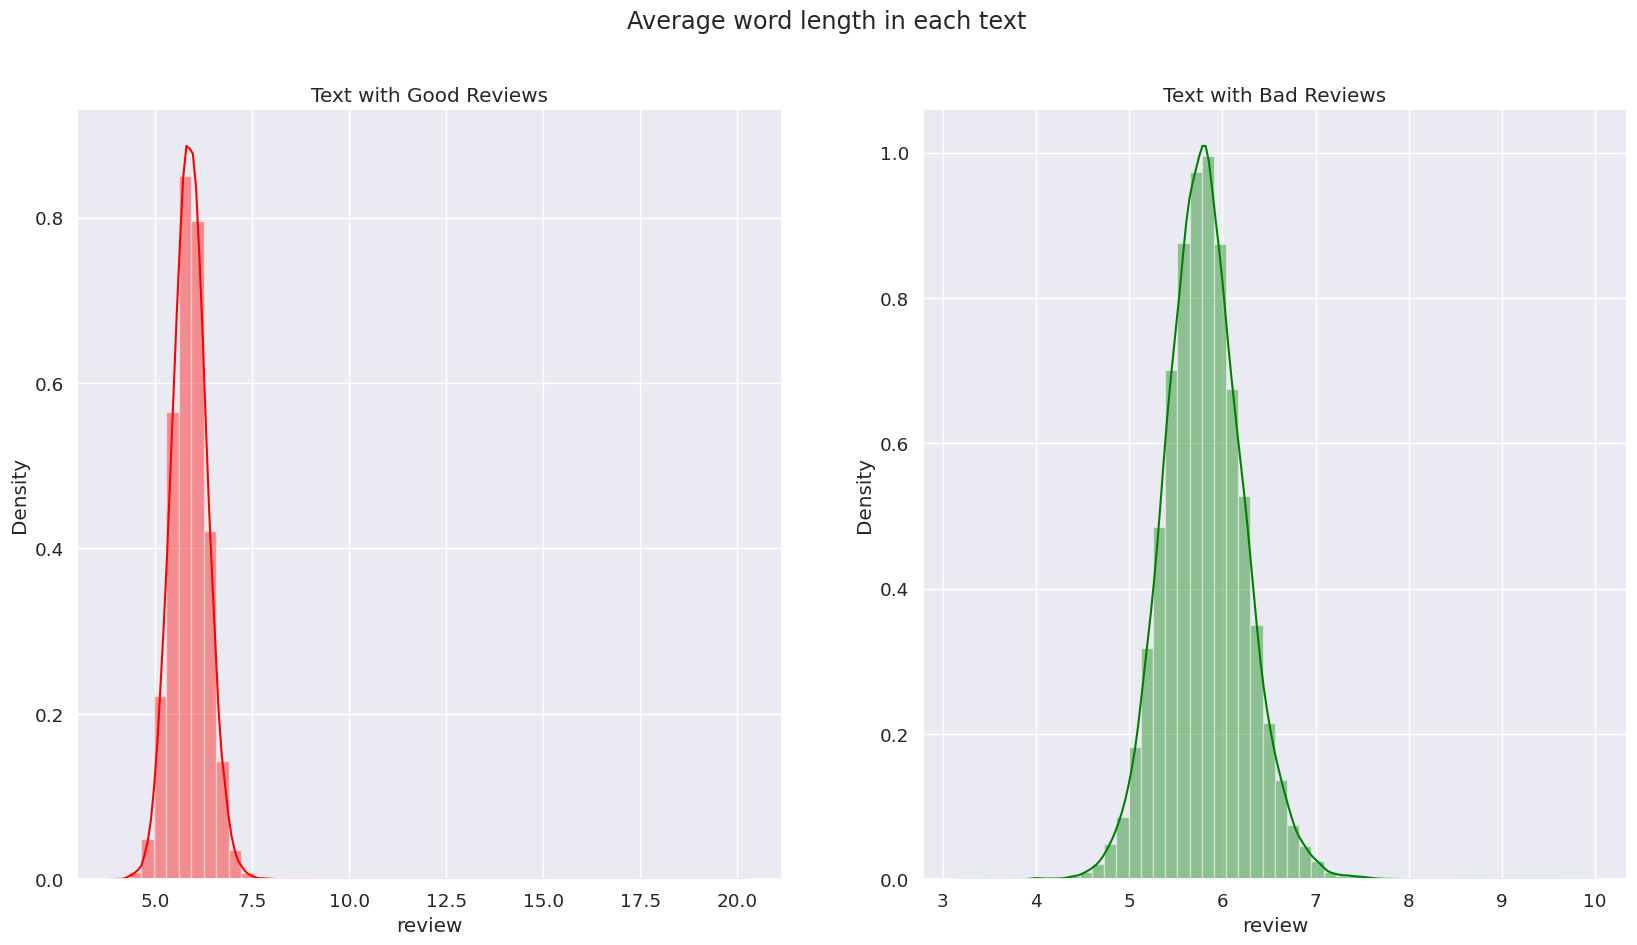

In [26]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['sentiment']==1]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Text with Good Reviews')
word=df[df['sentiment']==0]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Average word length in each text')

In [27]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['one', 'reviewers', 'mentioned', 'watching', 'oz']

In [28]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 61496,
 'film': 55088,
 'one': 45067,
 'like': 37303,
 'would': 23815,
 'even': 23720,
 'good': 23475,
 'really': 21806,
 'see': 20906,
 'get': 17692}

In [29]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [30]:
most_common_uni = get_top_text_ngrams(df.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [31]:
most_common_bi = get_top_text_ngrams(df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [32]:
most_common_tri = get_top_text_ngrams(df.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h',
             width=700, height=700,color='Common_words')
fig.show()

In [33]:
#ENCODE
# The 'sentiment' column already contains 0s (negative) and 1s (positive) after previous processing.
# The label_map was intended for string labels, but the 'sentiment' column is already numeric.
# Assign the existing numerical sentiment to the 'label' column.
df['label'] = df['sentiment']

X = df['clean_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training samples: {len(X_train)}')
print(f'Testing samples: {len(X_test)}')


Training samples: 39999
Testing samples: 10000


In [34]:
from transformers import DistilBertTokenizer # Changed from BertTokenizer

#TOKENIZATION DENGAN BERT
# Load BERT tokenizer
model_name = 'distilbert-base-uncased' # Changed from bert-base-uncased for consistency
tokenizer = DistilBertTokenizer.from_pretrained(model_name)

max_len = 128

print('Tokenizing data...')

# Tokenize training data
train_encodings = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)

# Tokenize testing data
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)

print(f'Tokenization complete!')
print(f'Training input shape: {train_encodings["input_ids"].shape}')
print(f'Testing input shape: {test_encodings["input_ids"].shape}')
print(f'Max sequence length: {max_len}')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Tokenizing data...
Tokenization complete!
Training input shape: (39999, 128)
Testing input shape: (10000, 128)
Max sequence length: 128


In [50]:
#BAGIAN 6
# Load pre-trained BERT model untuk klasifikasi 3 kelas
from transformers import TFDistilBertForSequenceClassification, create_optimizer # Added create_optimizer
import tensorflow as tf # Import tensorflow to explicitly reference tf.keras.optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model = TFDistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2, # Changed from 3 to 2 for binary classification
    from_pt=True  # Load dari PyTorch weights
)

# Define training parameters for create_optimizer
# Assuming batch_size=16 and epochs=3 for compilation setup.
# These will be explicitly used when calling model.fit().
batch_size = 16
epochs = 5

num_train_steps = (len(X_train) // batch_size) * epochs
num_warmup_steps = int(0.1 * num_train_steps) # 10% warmup steps

# Use create_optimizer from transformers
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=num_warmup_steps,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01 # A common default
)

# Use model.compute_loss for Hugging Face models when labels are in the input dictionary
model.compile(
    optimizer=optimizer,
    loss=model.compute_loss, # Changed from SparseCategoricalCrossentropy
    metrics=['accuracy']
)

print('Model BERT berhasil diload dan dikompilasi')
print(f'Model: {model_name}')
print(f'Number of labels: 2 (Negative, Positive)') # Updated description
print(f'Initial Learning rate: 2e-5')
print(f'Epochs for optimizer setup: {epochs}')
print(f'Batch size for optimizer setup: {batch_size}')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

Model BERT berhasil diload dan dikompilasi
Model: distilbert-base-uncased
Number of labels: 2 (Negative, Positive)
Initial Learning rate: 2e-5
Epochs for optimizer setup: 5
Batch size for optimizer setup: 16


In [ ]:
# TRAINING MODEL (Simplified and Fixed for Faster Runtime)
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Assuming X_train, y_train, tokenizer, max_len, batch_size, epochs are defined
# Split data first (before tokenizing to avoid re-tokenizing)
X_sub_train, X_val, y_sub_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

# Tokenize once for sub_train and val (faster than re-tokenizing)
sub_train_encodings = tokenizer(
    X_sub_train.tolist(),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)
val_encodings = tokenizer(
    X_val.tolist(),
    truncation=True,
    padding=True,
    max_length=max_len,
    return_tensors='tf'
)

# Simplified datasets (no shuffle or prefetch to reduce overhead)
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(sub_train_encodings),
    y_sub_train
)).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(batch_size)

print('Training BERT model...')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print('Simplified setup for faster runtime (no callbacks, fixed model compile)')
print()

# Compile model (necessary for training Transformers models) - Use string for optimizer
model.compile(
    optimizer='adam',  # Use string 'adam' instead of object to avoid ValueError
    loss='binary_crossentropy',  # For binary classification (SST-2)
    metrics=['accuracy']
)

# Train model (removed callbacks to avoid AttributeError)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    verbose=1
)

print("\nTraining selesai!")



Training BERT model...
Epochs: 5
Batch size: 16
Simplified setup for faster runtime (no callbacks, fixed model compile)

Epoch 1/5
1585/2125 [=====================>........] - ETA: 1:10:55 - loss: 7.6613 - accuracy: 0.5015

COBA AKHIR

## 3. Preprocessing Teks
### Tokenisasi & Padding

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Assuming X_train and X_test are already defined as arrays of clean text from previous steps
# (e.g., from df['clean_text'] after train_test_split as X, y -> X_train, X_test, y_train, y_test)

# Initialize Keras Tokenizer
# num_words can be set based on vocabulary size you want to consider
# Or it can be left None to consider all words, and then vocab_size is derived from word_index length
num_words = 10000 # Example: consider top 10,000 words
tokenizer_lstm = Tokenizer(num_words=num_words, oov_token="<unk>")

# Fit tokenizer on training texts
tokenizer_lstm.fit_on_texts(X_train)

# Convert text to sequences of integers
x_train = tokenizer_lstm.texts_to_sequences(X_train)
x_test = tokenizer_lstm.texts_to_sequences(X_test)

# Padding
maxlen = 250 # Max sequence length for LSTM input
x_train_pad = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

# Convert labels to numpy (if not already, and using y_train from df preprocessing)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Define vocab_size based on the tokenizer
vocab_size = len(tokenizer_lstm.word_index) + 1 # +1 for the 0 padding index or OOV token

print(f'Original X_train shape: {X_train.shape}')
print(f'Original X_test shape: {X_test.shape}')
print(f'Padded x_train_pad shape: {x_train_pad.shape}')
print(f'Padded x_test_pad shape: {x_test_pad.shape}')
print(f'Vocabulary size: {vocab_size}')
print(f'Max sequence length (maxlen): {maxlen}')

Original X_train shape: (39999,)
Original X_test shape: (10000,)
Padded x_train_pad shape: (39999, 250)
Padded x_test_pad shape: (10000, 250)
Vocabulary size: 76197
Max sequence length (maxlen): 250


## 4. Bangun Model LSTM

In [ ]:
model = Sequential([
    Embedding(vocab_size, 128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


## 5. Training Model

In [ ]:
history = model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2
)


## 6. Evaluasi Model
### Accuracy & Loss Plot

In [ ]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy')
plt.show()


### Confusion Matrix & Classification Report

In [ ]:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))


# 7. Prediksi Teks Baru

In [ ]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text.lower()])
    pad = pad_sequences(seq, maxlen=maxlen)
    pred = model.predict(pad)[0][0]
    return "Positive" if pred > 0.5 else "Negative"

print(predict_sentiment("This movie is absolutely wonderful!"))


## 8. Simpan Model & Tokenizer

In [ ]:
import pickle

# Save model
model.save("sentiment_lstm.h5")

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
